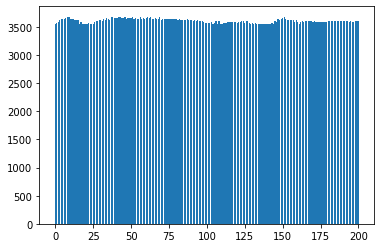

best workload found: [3560. 3574. 3588. 3624. 3637. 3637. 3647. 3665. 3676. 3681. 3643. 3635.
 3638. 3627. 3618. 3618. 3546. 3588. 3561. 3557. 3546. 3556. 3569. 3548.
 3552. 3551. 3594. 3598. 3607. 3620. 3626. 3610. 3642. 3631. 3656. 3637.
 3626. 3681. 3680. 3656. 3662. 3655. 3676. 3683. 3654. 3662. 3675. 3642.
 3660. 3654. 3652. 3673. 3643. 3653. 3646. 3645. 3671. 3642. 3668. 3642.
 3667. 3676. 3666. 3683. 3651. 3651. 3656. 3641. 3637. 3676. 3630. 3638.
 3639. 3639. 3635. 3636. 3638. 3648. 3646. 3648. 3640. 3628. 3645. 3626.
 3628. 3624. 3622. 3634. 3619. 3625. 3622. 3607. 3619. 3606. 3621. 3606.
 3608. 3603. 3581. 3580. 3572. 3578. 3575. 3597. 3547. 3574. 3602. 3555.
 3598. 3546. 3549. 3574. 3572. 3566. 3587. 3585. 3585. 3587. 3584. 3593.
 3568. 3596. 3597. 3607. 3607. 3573. 3604. 3607. 3564. 3546. 3573. 3548.
 3563. 3552. 3548. 3550. 3559. 3550. 3558. 3548. 3548. 3555. 3555. 3573.
 3552. 3606. 3590. 3634. 3624. 3645. 3665. 3682. 3643. 3631. 3630. 3620.
 3628. 3628. 3595. 3619. 3582.

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import re
from itertools import compress
from copy import deepcopy

allowableTime = 2 # time allowed in seconds
p = 1 + np.random.randint(1000, size = 612) # job processing times
p = np.append(p, 1 + np.random.randint(2001, size = 132))
p = np.append(p, 1 + 1 + np.random.negative_binomial(n = 1500, p = 0.5, size = 201))
m = 201 # number of machines
inst = np.append(allowableTime,np.append(m,p))

### creating an example txt instance

txter = open("instance.txt", "w")
for item in inst:
    txter.write(str(item))
    txter.write('\n')
txter.close()
    
### Given an instance will be of the form (𝑝1,𝑝2,⋯,𝑝𝑛,𝑚) we need to read the txt file in this way. We can then chop it up for the agent to manipulate

def import_inst(filename):
    '''
    imports a text file instance, converts it to an array and then allocates it to p and m, 
    where p are the jobs and m is the number of machines
    '''
    inst = list(map(int, re.findall('\d+', str([line.rstrip('\n') for line in open(filename)]))))
    global p, m, allowableTime
    p =  inst[2:]
    p.sort()
    p = p[::-1]
    m = inst[1]
    allowableTime = inst[0]

import_inst("instance.txt")


class agent:
    def __init__(self): 
        self.initialTime = time.time()
        self.allocation = {} # a dict for tracking  the allocated jobs to machines
        self.workload = np.zeros(m) # np.array of length m, where self.workload[machine] = sum of processing times of jobs assigned to machine
        self.cost = None # cost of current feasible solution
        self.costTrajectory = [] # list of cost of feasible solution found in each step
        self.workload_so_far = []
        self.allocation_so_far = []

        
    # generates a greedy initial feasible solution
    def generateGreedySolution(self):
        for i in range(m):
            self.allocation[i] = [p[i]]
            self.workload[i] += p[i]
        for i in range(m,len(p)):
            worker = np.argmin(self.workload)
            self.allocation[worker].append(p[i])
            self.workload[worker] += p[i]
        self.cost = np.max(self.workload)
        self.costTrajectory.append(self.cost)
        
        
    # switch assigned machine of 'job' to 'toMachine'
    def switchMachine(self,  job, fromMachine, toMachine):
        self.workload[fromMachine] += - job
        self.allocation[fromMachine].remove(job)
        self.workload[toMachine] += job
        self.allocation[toMachine].append(job)
    
    def Swap(self, Big, big_candidate, Small, small_candidate):
        self.switchMachine(Big, big_candidate, small_candidate)
        self.switchMachine(Small, small_candidate, big_candidate)
    
    def greedySearchIteration(self,k):
        ind = np.argsort(self.workload)
        for i in range(k):
            big_candidate = ind[-(i+1)]
            small_candidate = ind[i]
            Big = np.max(self.allocation[big_candidate])
            Small = np.max(list(compress(self.allocation[small_candidate],
                                     [i < Big for i in self.allocation[small_candidate]])))
            self.Swap(Big, big_candidate, Small, small_candidate)
        self.cost = np.max(self.workload)
        self.costTrajectory.append(self.cost)
        self.workload_so_far.append(deepcopy(self.workload))
        self.allocation_so_far.append(deepcopy(self.allocation))
    
    def print_results(self):
        plt.bar(range(m),self.workload)
        plt.show()
        print('best workload found:', self.workload)
        print('best allocation found:', self.allocation)
        print('neighbours visited:', self.costTrajectory)
        print('approximation ratio:',  self.cost/np.average(self.workload))
        print('time taken:', time.time() - self.initialTime)
    
    def greedySearch(self,totalTime,k):
        self.generateGreedySolution()
        self.workload_so_far.append(deepcopy(self.workload))
        self.allocation_so_far.append(deepcopy(self.allocation))
        while time.time() - self.initialTime < totalTime - 0.31:
            self.greedySearchIteration(k)
            if self.cost > self.costTrajectory[-2]:
                self.workload = deepcopy(self.workload_so_far[-2])
                self.allocation = deepcopy(self.allocation_so_far[-2])
                self.cost = np.max(self.workload)
                self.costTrajectory.append(self.cost) 
                self.print_results()
                return
            if self.cost == self.costTrajectory[-2]:
                self.print_results()
                return
        print('*****ALLOCATED TIME EXPIRED!*****')
        print('BEST RESULT:')
        self.print_results()
    
    def verifyFeasibleSolution(self):
        # check that each job is assigned to exactly one machine
        assert(sum([len(self.allocation[i]) for i in range(m)]) == len(p))
        # check that there are at most m machines that have jobs assigned to them
        assert(len(self.allocation) <= m)

        # check that the workloads are as indicated in A.workload
        for i in range(m):
            assert(self.workload[i] == sum(self.allocation[i]))

        # check that the maximum of the workloads (i.e. the cost) is as indicated in A.cost
        assert(np.isclose(self.cost, np.max(self.workload)))
            
    
            
A = agent()
A.greedySearch(allowableTime,2)
A.verifyFeasibleSolution()


### Greedy makespan allocation algo is on pg 262 of text

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import re
from itertools import compress


In [2]:
def import_inst(filename):
    '''
    imports a text file instance, converts it to an array and then allocates it to p and m, 
    where p are the jobs and m is the number of machines
    '''
    inst = list(map(int, re.findall('\d+', str([line.rstrip('\n') for line in open(filename)]))))
    global p, m, allowableTime
    p =  inst[2:]
    p.sort()
    p = p[::-1]
    m = inst[1]
    allowableTime = inst[0]

import_inst("instance.txt")

In [20]:
global workload, allocation, costTrajectory, cost
allocation = {}
workload = np.zeros(m)
costTrajectory = []

In [21]:
#greedy allocation
for i in range(m):
    allocation[i] = [p[i]]
    workload[i] += p[i]
for i in range(m,len(p)):
    worker = np.argmin(workload)
    allocation[worker].append(p[i])
    workload[worker] += p[i]
cost = np.max(workload)
costTrajectory.append(cost)


In [15]:
def switchMachine(self,  job, fromMachine, toMachine):
    workload[fromMachine] += - job
    allocation[fromMachine].remove(job)
    workload[toMachine] += job
    allocation[toMachine].append(job)

In [40]:
def Swap(self, Big, big_candidate, Small, small_candidate):
    self.switchMachine(Big, big_candidate, small_candidate)
    self.switchMachine(Small, small_candidate, big_candidate)

In [35]:
ind_machine = np.argsort(workload)

In [43]:
ind_alloc = np.max(allocation[120])

In [44]:
ind_alloc

1512

In [45]:
k = 1
for i in range(k):
    print(ind[i])
    print(ind[-(i+1)])

120
47


In [26]:
W = workload.copy()

In [28]:
W

array([3644., 3640., 3642., 3658., 3659., 3664., 3668., 3671., 3672.,
       3675., 3677., 3678., 3683., 3690., 3688., 3688., 3692., 3671.,
       3679., 3629., 3629., 3633., 3626., 3641., 3654., 3654., 3664.,
       3669., 3671., 3662., 3688., 3683., 3683., 3678., 3685., 3682.,
       3681., 3706., 3715., 3701., 3700., 3715., 3690., 3693., 3700.,
       3699., 3697., 3718., 3682., 3680., 3680., 3682., 3681., 3681.,
       3681., 3716., 3689., 3695., 3677., 3681., 3677., 3684., 3683.,
       3683., 3676., 3679., 3677., 3706., 3654., 3681., 3666., 3653.,
       3662., 3654., 3654., 3659., 3655., 3655., 3654., 3659., 3653.,
       3661., 3660., 3662., 3653., 3653., 3645., 3654., 3639., 3654.,
       3652., 3654., 3638., 3635., 3649., 3646., 3641., 3644., 3645.,
       3645., 3640., 3642., 3640., 3644., 3640., 3642., 3640., 3627.,
       3643., 3637., 3641., 3642., 3635., 3641., 3634., 3631., 3626.,
       3625., 3626., 3625., 3624., 3626., 3625., 3629., 3630., 3628.,
       3626., 3629.,

In [30]:
W[47]

3718.0

In [31]:
kz = np.argsort(W)

In [32]:
kz

array([120, 134, 117, 119, 122, 118, 184,  22, 121, 126, 116, 178, 176,
       174, 107, 186, 188, 132, 125, 177, 180,  19,  20, 129, 123, 170,
       127, 124, 171, 169, 156, 115, 157, 198, 185, 128, 131, 130, 133,
       153, 155, 175, 182,  21, 183, 197, 172, 114, 167, 168, 181, 199,
       112,  93, 179, 187, 163, 109, 200,  92, 160,  88, 106, 104, 102,
       173, 100,   1, 191, 195, 110,  96,  23, 113, 154, 190, 111, 105,
       101,   2, 189, 152, 108, 166, 149, 151, 103,  97,   0,  99,  98,
        86, 159, 158,  95, 161, 165, 162, 164,  94, 196, 194,  90,  84,
        71,  80, 193,  85,  74,  68,  73,  25,  24,  89,  78,  87,  91,
        76,  77, 192, 150,   3,   4,  75,  79,  82,  81, 147,  83, 135,
        72,  29,  26,   5, 146, 139,  70,   6, 143,  27, 145,  28,   7,
        17,   8, 144,   9, 148,  64, 141, 142, 140,  10,  58,  66,  60,
        33,  11,  18,  65,  49,  50,  36,  52,  53,  69,  54, 136,  59,
        48,  35,  51,  12,  31,  62,  63,  32, 137,  61,  34,  1

In [33]:
kz[0]

120

In [34]:
kz[-1]

47

In [24]:
W.sort()
W

array([3624., 3624., 3625., 3625., 3625., 3626., 3626., 3626., 3626.,
       3626., 3626., 3626., 3626., 3627., 3627., 3628., 3628., 3628.,
       3628., 3628., 3629., 3629., 3629., 3629., 3629., 3629., 3629.,
       3630., 3630., 3630., 3631., 3631., 3632., 3632., 3632., 3632.,
       3632., 3632., 3632., 3632., 3632., 3632., 3632., 3633., 3633.,
       3633., 3633., 3634., 3634., 3634., 3634., 3634., 3635., 3635.,
       3636., 3636., 3637., 3637., 3638., 3638., 3639., 3639., 3640.,
       3640., 3640., 3640., 3640., 3640., 3641., 3641., 3641., 3641.,
       3641., 3641., 3641., 3642., 3642., 3642., 3642., 3642., 3643.,
       3643., 3643., 3643., 3644., 3644., 3644., 3644., 3644., 3645.,
       3645., 3645., 3646., 3646., 3646., 3648., 3648., 3648., 3648.,
       3649., 3649., 3651., 3652., 3653., 3653., 3653., 3653., 3653.,
       3654., 3654., 3654., 3654., 3654., 3654., 3654., 3654., 3654.,
       3655., 3655., 3658., 3658., 3658., 3659., 3659., 3659., 3660.,
       3661., 3661.,

In [18]:
workload

array([3624., 3624., 3625., 3625., 3625., 3626., 3626., 3626., 3626.,
       3626., 3626., 3626., 3626., 3627., 3627., 3628., 3628., 3628.,
       3628., 3628., 3629., 3629., 3629., 3629., 3629., 3629., 3629.,
       3630., 3630., 3630., 3631., 3631., 3632., 3632., 3632., 3632.,
       3632., 3632., 3632., 3632., 3632., 3632., 3632., 3633., 3633.,
       3633., 3633., 3634., 3634., 3634., 3634., 3634., 3635., 3635.,
       3636., 3636., 3637., 3637., 3638., 3638., 3639., 3639., 3640.,
       3640., 3640., 3640., 3640., 3640., 3641., 3641., 3641., 3641.,
       3641., 3641., 3641., 3642., 3642., 3642., 3642., 3642., 3643.,
       3643., 3643., 3643., 3644., 3644., 3644., 3644., 3644., 3645.,
       3645., 3645., 3646., 3646., 3646., 3648., 3648., 3648., 3648.,
       3649., 3649., 3651., 3652., 3653., 3653., 3653., 3653., 3653.,
       3654., 3654., 3654., 3654., 3654., 3654., 3654., 3654., 3654.,
       3655., 3655., 3658., 3658., 3658., 3659., 3659., 3659., 3660.,
       3661., 3661.,